In [1]:
import os
import pandas as pd
import cv2
from skimage.feature import hog

In [2]:
path="C:/Users/Admin/Downloads/IP-dataset/DataSet/all_dataset_new_compressed"
#path2="C:/Users/Admin/Downloads/IP-dataset/Annotated_dataset/demo"

In [3]:
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
import numpy as np
import mahotas.features
har_features=[]
grey_features=[]
names=[]
label=[]
data=[]
hu_features=[]
c=0
hog_fd=[]
hist_features=[]
for folder in os.listdir(path):
    if folder == 'bees':
        for file in os.listdir(os.path.join(path,folder)):
            if(file!='desktop.ini'):
                names.append(file)
                label.append(1)
                img=cv2.imread(os.path.join(os.path.join(path,folder),file))
                img=cv2.resize(img,(64,64))
                fd= hog(img,orientations=8,pixels_per_cell=(16,16),cells_per_block=(1,1),multichannel=True)
                hog_fd.append(fd)
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                hist = cv2.calcHist([hsv], [0, 1, 2], None, [8,8,8],
                    [0, 180, 0, 256, 0, 256])
                hist = cv2.normalize(hist,hist)
                # return the flattened histogram as the feature vector
                td_hist = hist.flatten()
                hist_features.append(td_hist)

                img2=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                hu= cv2.HuMoments(cv2.moments(img2)).flatten()
                hu_features.append(hu)
                normalizedImg = np.zeros((64,64))
                norm_img= cv2.normalize(img2,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                f = greycomatrix(norm_img, distances =[1], angles =[0,np.pi/4,np.pi/2,3*np.pi/4], levels = 256, symmetric=True,normed=True)
                img_c = greycoprops(f, 'contrast')
                img_d=greycoprops(f, 'dissimilarity')
                img_corr=greycoprops(f, 'correlation')
                img_c=list(img_c[0])
                img_c.extend(img_d[0])
                img_c.extend(img_corr[0])
                grey_features.append(img_c)
                img=img.flatten()
                data.append(img)
                c=c+1
                
    if folder =='non_bees':
        for file in os.listdir(os.path.join(path,folder)):
            if(file!='desktop.ini'):
                names.append(file)
                label.append(0)
                img=cv2.imread(os.path.join(os.path.join(path,folder),file))
                img=cv2.resize(img,(64,64))
                fd= hog(img,orientations=8,pixels_per_cell=(16,16),cells_per_block=(1,1),multichannel=True)
                hog_fd.append(fd)
                hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                hist = cv2.calcHist([hsv], [0, 1, 2], None, [8,8,8],
                    [0, 180, 0, 256, 0, 256])
                hist = cv2.normalize(hist,hist)
                # return the flattened histogram as the feature vector
                td_hist = hist.flatten()
                hist_features.append(td_hist)

                img2=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
                hu= cv2.HuMoments(cv2.moments(img2)).flatten()
                hu_features.append(hu)
                normalizedImg = np.zeros((64,64))
                norm_img= cv2.normalize(img2,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
                f = greycomatrix(norm_img, distances =[1], angles =[0,np.pi/4,np.pi/2,3*np.pi/4], levels = 256, symmetric=True,normed=True)
                img_c = greycoprops(f, 'contrast')
                img_d=greycoprops(f, 'dissimilarity')
                img_corr=greycoprops(f, 'correlation')
                img_c=list(img_c[0])
                img_c.extend(img_d[0])
                img_c.extend(img_corr[0])
                grey_features.append(img_c)
#                 img2 = mahotas.imread(os.path.join(os.path.join(path,folder),file))
#                 feature=mahotas.features.haralick(img2).mean(0)
#                 har_features.append(feature)
                img=img.flatten()
                data.append(img)
                c=c+1
        
print("count",c)

C:\Users\Admin\Anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


count 7769


In [4]:
import numpy as np
images_np=np.array(data)
hog_np=np.array(hog_fd)
data_hog=np.concatenate((images_np,hog_np),axis=1)
data_hog_hist=np.concatenate((data_hog,hist_features),axis=1)
data_hog_hist_grey=np.concatenate((data_hog_hist,grey_features),axis=1)
# data_hog_hist_har=np.concatenate((data_hog_hist,har_features),axis=1)
data_hog_hist_grey_hu=np.concatenate((data_hog_hist_grey,hu_features),axis=1)

In [5]:
dfname=pd.DataFrame(names)
dflabel=pd.DataFrame(label)

In [6]:
import numpy as np
len(names)

7769

In [7]:
len(os.listdir(path))

2

In [8]:
dfname.columns=['id']
dflabel.columns=['label']

In [9]:
df_concat = pd.concat([dfname, dflabel], axis=1)

In [10]:
df_concat.to_csv("C:/Users/Admin/Downloads/IP-dataset/Annotated_dataset/demo/labels.csv")

In [11]:
len(df_concat[df_concat['label']==1])

4498

# HOG+HIST+GREY features

In [14]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(data_hog_hist_grey,np.array(label),test_size=0.3,random_state=42)
len(X_train)

5438

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score,matthews_corrcoef
from sklearn.metrics import average_precision_score,f1_score
model=XGBClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
kappa=cohen_kappa_score(y_test,y_pred)
mcc=matthews_corrcoef(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Accuracy",accuracy)
print("Kappa",kappa)
print("MCC",mcc)
print("F1",f1)
#print(avg_precision)

0.804804804805
0.591562725403
0.593459710272


avg_precision 0.915013399926


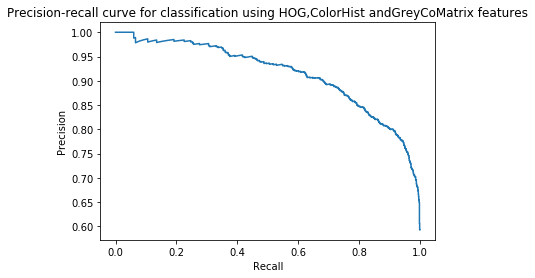

In [16]:
#precision_recalll_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
#y_score = model.decision_function(X_test)
y_score=model.predict_proba(X_test)[:,1]
#f1 = f1_score(y_test, y_score)
precision, recall, _ = precision_recall_curve(y_test, y_score)
#print("f1 score",f1)
plt.plot(recall,precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-recall curve for classification using HOG,ColorHist andGreyCoMatrix features")

fig5=plt.gcf()
plt.show()
plt.draw()
fig5.savefig('5_HOG_Hist_Grey_pr', dpi=100)

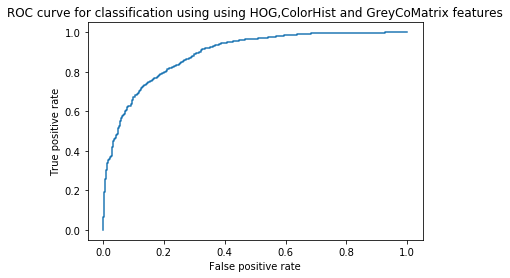

In [17]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds =roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve for classification using using HOG,ColorHist and GreyCoMatrix features")

fig6=plt.gcf()
plt.show()
plt.draw()
fig6.savefig('6_HOG_Hist_Grey_roc', dpi=100)

# HOG+HIST+GREY+HU features

In [18]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(data_hog_hist_grey_hu,np.array(label),test_size=0.3,random_state=42)

In [19]:
len(X_train)

5438

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score,matthews_corrcoef
from sklearn.metrics import average_precision_score,f1_score
model=XGBClassifier()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_test,y_pred)
kappa=cohen_kappa_score(y_test,y_pred)
mcc=matthews_corrcoef(y_test,y_pred)
f1=f1_score(y_test,y_pred)

print("Accuracy",accuracy)
print("Kappa",kappa)
print("MCC",mcc)
print("F1",f1)

0.807807807808
0.597909707109
0.599783406147


avg_precision 0.912742213326


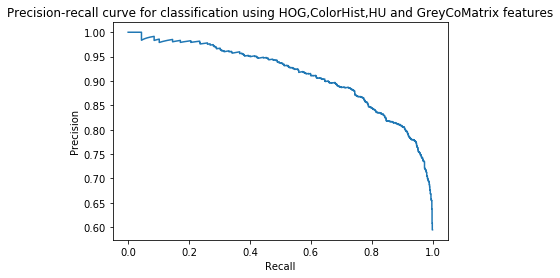

In [21]:
#precision_recalll_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
#y_score = model.decision_function(X_test)
y_score=model.predict_proba(X_test)[:,1]
#f1 = f1_score(y_test, y_score)
precision, recall, _ = precision_recall_curve(y_test, y_score)
#print("f1 score",f1)
plt.plot(recall,precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-recall curve for classification using HOG,ColorHist,HU and GreyCoMatrix features")
fig7=plt.gcf()
plt.show()
plt.draw()
fig7.savefig('7_HOG_Hist_Grey_Hu_pr', dpi=100)

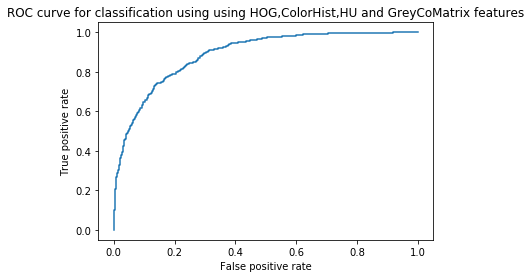

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds =roc_curve(y_test, y_score)
plt.plot(fpr,tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve for classification using using HOG,ColorHist,HU and GreyCoMatrix features")
fig8=plt.gcf()
plt.show()
plt.draw()
fig8.savefig('8_HOG_Hist_Grey_Hu_roc', dpi=100)